In [1]:
import torch 
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt 
from tqdm import tqdm

device="cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchvision.__version__)

2.0.0
0.15.0


In [2]:
from pathlib import Path
from helper_functions import walk_through_dir

data_path=Path("data/")
image_path = data_path / "militaryvsother"
walk_through_dir(image_path)

There are 3 directories and 0 images in 'data\militaryvsother'.
There are 2 directories and 0 images in 'data\militaryvsother\test'.
There are 0 directories and 1281 images in 'data\militaryvsother\test\millitary'.
There are 0 directories and 1511 images in 'data\militaryvsother\test\other'.
There are 2 directories and 0 images in 'data\militaryvsother\train'.
There are 0 directories and 5125 images in 'data\militaryvsother\train\millitary'.
There are 0 directories and 6045 images in 'data\militaryvsother\train\other'.
There are 2 directories and 0 images in 'data\militaryvsother\validation'.
There are 0 directories and 1602 images in 'data\militaryvsother\validation\millitary'.
There are 0 directories and 1889 images in 'data\militaryvsother\validation\other'.


In [3]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/militaryvsother/train'),
 WindowsPath('data/militaryvsother/test'))

Random image path: data\militaryvsother\train\millitary\millitary_0_4610.jpeg
Image class: millitary
Image height: 256
Image width: 256


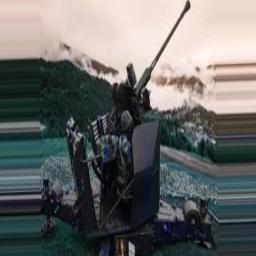

In [4]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpeg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

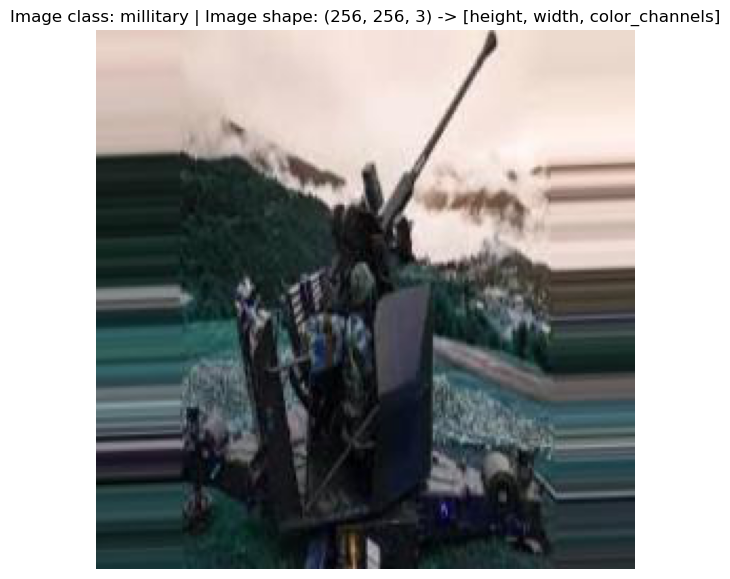

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);


In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transformer=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

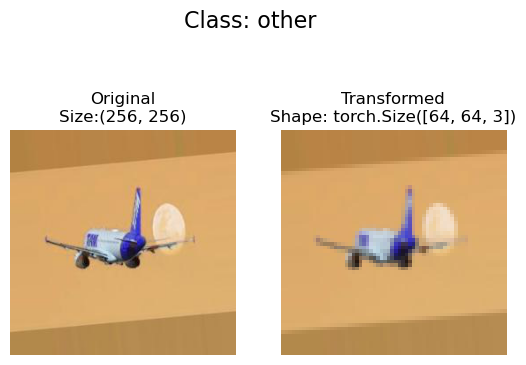

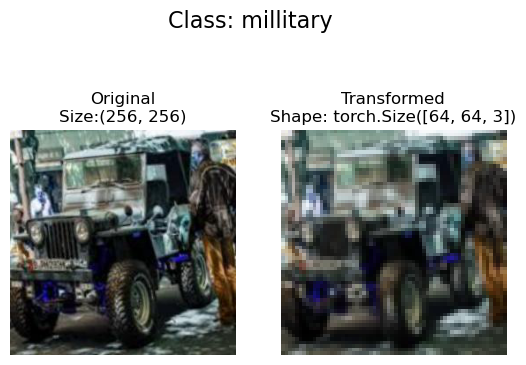

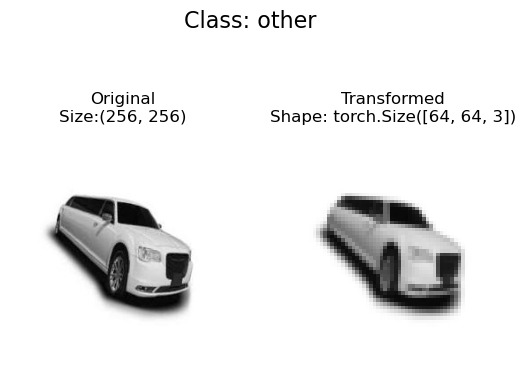

In [7]:
from helper_functions import plot_transformed_images

plot_transformed_images(image_path_list,transform=data_transformer)

In [8]:
from torchvision import datasets

train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transformer,
                                target_transform=None)

test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transformer)
print(f"Train Data:\n{train_data}\nTest Data:\n{test_data}")

Train Data:
Dataset ImageFolder
    Number of datapoints: 11170
    Root location: data\militaryvsother\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test Data:
Dataset ImageFolder
    Number of datapoints: 2792
    Root location: data\militaryvsother\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [9]:
#train data size, test data size and percentage of test to train
len(train_data),len(test_data),(len(test_data)/(len(train_data)+len(test_data))*100)

(11170, 2792, 19.997135080933965)

In [10]:
classes=train_data.classes
class_dict=train_data.class_to_idx
classes,class_dict

(['millitary', 'other'], {'millitary': 0, 'other': 1})

In [11]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE=128
NUM_WORKERS=os.cpu_count()

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            shuffle=True)


test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           num_workers=NUM_WORKERS,
                           shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1af67709c10>,
 <torch.utils.data.dataloader.DataLoader at 0x1af67709bb0>)

In [12]:
from helper_functions import set_seeds
set_seeds()

class MilitaryNormalClassModel(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1), #hyperparameters of Conv2d
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)#kernel size can also be a tuple such as (2,2)

        )
        self.conv_block_2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier_layer=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)#out features -> class_names
        )

    def forward(self,x:torch.tensor):
        x=self.conv_block_1(x)
        #print(f"Output shape after conv block 1: {x.shape}")
        x=self.conv_block_2(x)
        #print(f"Output shape after conv block 2: {x.shape}")
        x=self.classifier_layer(x)
        #print(f"Output shape after classifier layer: {x.shape}")
        return x

In [13]:
model_0=MilitaryNormalClassModel(input_shape=3,
                                 hidden_units=10,
                                 output_shape=len(classes)).to(device)

In [14]:
#Setup loss function eval metrics and optimizer
from helper_functions import accuracy_fn

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [15]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from helper_functions import print_train_time, test_step, train_step 

from timeit import default_timer as timer


train_time_start_model_0=timer()

epochs=10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}\n-------------")
    train_step(model=model_0,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_0,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
train_time_end_model_0=timer()
total_train_time_model_2=print_train_time(start=train_time_start_model_0,
                                          end=train_time_end_model_0,
                                          device=device)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1
-------------
Train loss: 0.68955 | Train acc: 54.04%


  4%|▍         | 1/25 [00:59<23:46, 59.42s/it]


Test loss: 0.6871, Test acc 54.2411
Epoch: 2
-------------
Train loss: 0.67739 | Train acc: 55.77%


  8%|▊         | 2/25 [01:48<20:30, 53.48s/it]


Test loss: 0.6640, Test acc 57.2143
Epoch: 3
-------------
Train loss: 0.63585 | Train acc: 64.54%


 12%|█▏        | 3/25 [02:37<18:50, 51.37s/it]


Test loss: 0.6380, Test acc 64.8393
Epoch: 4
-------------
Train loss: 0.61731 | Train acc: 66.56%


 16%|█▌        | 4/25 [03:27<17:44, 50.68s/it]


Test loss: 0.6510, Test acc 59.3571
Epoch: 5
-------------
Train loss: 0.55799 | Train acc: 71.74%


 20%|██        | 5/25 [04:16<16:44, 50.23s/it]


Test loss: 0.8743, Test acc 59.6875
Epoch: 6
-------------
Train loss: 0.51789 | Train acc: 74.70%


 24%|██▍       | 6/25 [05:06<15:51, 50.09s/it]


Test loss: 0.5819, Test acc 68.2589
Epoch: 7
-------------
Train loss: 0.50617 | Train acc: 75.36%


 28%|██▊       | 7/25 [05:56<14:59, 49.95s/it]


Test loss: 0.9983, Test acc 54.8839
Epoch: 8
-------------
Train loss: 0.49458 | Train acc: 76.43%


 32%|███▏      | 8/25 [06:45<14:08, 49.92s/it]


Test loss: 1.2119, Test acc 56.5893
Epoch: 9
-------------
Train loss: 0.48059 | Train acc: 77.37%


 36%|███▌      | 9/25 [07:35<13:18, 49.88s/it]


Test loss: 0.5276, Test acc 73.4286
Epoch: 10
-------------
Train loss: 0.46782 | Train acc: 78.04%


 40%|████      | 10/25 [08:25<12:26, 49.80s/it]


Test loss: 0.6238, Test acc 68.3036
Epoch: 11
-------------
Train loss: 0.45884 | Train acc: 78.85%


 44%|████▍     | 11/25 [09:14<11:33, 49.50s/it]


Test loss: 0.8207, Test acc 61.4286
Epoch: 12
-------------
Train loss: 0.45350 | Train acc: 79.22%


 48%|████▊     | 12/25 [10:03<10:42, 49.39s/it]


Test loss: 0.6904, Test acc 63.0893
Epoch: 13
-------------
Train loss: 0.44842 | Train acc: 79.20%


 52%|█████▏    | 13/25 [10:53<09:56, 49.70s/it]


Test loss: 0.7106, Test acc 64.8036
Epoch: 14
-------------
Train loss: 0.44313 | Train acc: 79.35%


 56%|█████▌    | 14/25 [11:42<09:02, 49.32s/it]


Test loss: 0.4216, Test acc 81.6161
Epoch: 15
-------------
Train loss: 0.43348 | Train acc: 79.75%


 60%|██████    | 15/25 [12:30<08:10, 49.00s/it]


Test loss: 0.6431, Test acc 68.7768
Epoch: 16
-------------
Train loss: 0.42939 | Train acc: 80.67%


 64%|██████▍   | 16/25 [13:17<07:16, 48.51s/it]


Test loss: 0.4069, Test acc 82.3304
Epoch: 17
-------------
Train loss: 0.41894 | Train acc: 80.95%


 68%|██████▊   | 17/25 [14:07<06:30, 48.80s/it]


Test loss: 1.2834, Test acc 55.9911
Epoch: 18
-------------
Train loss: 0.41455 | Train acc: 81.26%


 72%|███████▏  | 18/25 [14:55<05:39, 48.50s/it]


Test loss: 0.6138, Test acc 72.4196
Epoch: 19
-------------
Train loss: 0.40803 | Train acc: 81.54%


 76%|███████▌  | 19/25 [15:43<04:50, 48.35s/it]


Test loss: 0.3882, Test acc 82.9554
Epoch: 20
-------------
Train loss: 0.40588 | Train acc: 82.04%


 80%|████████  | 20/25 [16:30<04:01, 48.20s/it]


Test loss: 0.7069, Test acc 64.9018
Epoch: 21
-------------
Train loss: 0.42378 | Train acc: 80.85%


 84%|████████▍ | 21/25 [17:18<03:12, 48.07s/it]


Test loss: 0.7078, Test acc 64.6607
Epoch: 22
-------------
Train loss: 0.40112 | Train acc: 82.23%


 88%|████████▊ | 22/25 [18:06<02:23, 47.97s/it]


Test loss: 0.3781, Test acc 82.8482
Epoch: 23
-------------
Train loss: 0.38637 | Train acc: 82.89%


 92%|█████████▏| 23/25 [18:53<01:35, 47.81s/it]


Test loss: 0.4975, Test acc 75.3214
Epoch: 24
-------------
Train loss: 0.38626 | Train acc: 82.94%


 96%|█████████▌| 24/25 [19:42<00:47, 47.91s/it]


Test loss: 0.5648, Test acc 70.7679
Epoch: 25
-------------
Train loss: 0.37640 | Train acc: 83.21%


100%|██████████| 25/25 [20:29<00:00, 49.19s/it]


Test loss: 0.6763, Test acc 69.2679

Train time on cuda: 1229.813 seconds
